## Key Components
1. State Management: Utilizes a `MusicState` class to manage the workflow's state.
2. Language Model: Employs LLAMA-3.3 Model generating musical components.
3. Musical Functions:
   - Melody Generator
   - Harmony Creator
   - Rhythm Analyzer
   - Style Adapter
4. MIDI Conversion: Transforms the composition into a playable MIDI file.
5. LangGraph Workflow: Orchestrates the composition process using a state graph.
6. Playback Functionality: Allows for immediate playback of the generated composition.

In [ ]:
!pip install langchain langchain_core langgraph langchain_community langchain_groq

In [ ]:
from typing import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain.prompts import ChatPromptTemplate
import music21
import tempfile
import random

##1. State Definition

In [ ]:
class MusicState(TypedDict):
  musician_input: str
  melody: str
  harmony: str
  rhythm: str
  style: str
  composition: str
  midi_file: str

##2. LLM Initialization

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    temperature = 0,
    groq_api_key = "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",
    model_name = "llama-3.3-70b-versatile"
)

result = llm.invoke("What is music?")

In [ ]:
result.content

'Music is a universal language that has been a part of human culture for thousands of years. It is a form of artistic expression that uses sound and silence to convey emotions, ideas, and experiences. Music can be defined as:\n\n1. **An arrangement of sounds**: Music is created by combining different sounds, such as melodies, harmonies, rhythms, and timbres, to produce a unique auditory experience.\n2. **A form of communication**: Music can express emotions, tell stories, and convey messages, making it a powerful tool for communication and connection.\n3. **A cultural phenomenon**: Music is shaped by social, historical, and cultural contexts, reflecting the values, traditions, and experiences of different communities and societies.\n4. **A creative expression**: Music is an art form that allows individuals to express themselves, their thoughts, and their feelings through composition, performance, and improvisation.\n\nMusic can take many forms, including:\n\n* **Vocal music**: Singing,

##3. Musical Node Functions

In [ ]:
def melody_generator(state: MusicState) -> Dict:
  prompt = ChatPromptTemplate.from_template(
      "Generate a melody based on this input: {input}. Represent it as a string of notes in music21 format"
  )
  chain = prompt | llm
  melody = chain.invoke({"input": state["musician_input"]})
  return {"melody":melody.content}

def harmony_creator(state: MusicState) -> Dict:
  prompt = ChatPromptTemplate.from_template(
      "Create harmony for this melody: {melody}. Represent it as a string of chords in music21 format"
  )
  chain = prompt | llm
  harmony = chain.invoke({"melody": state["melody"]})
  return {"harmony":harmony.content}

def rhythm_analyzer(state: MusicState) -> Dict:
  prompt = ChatPromptTemplate.from_template(
      "Analyze and suggest a rhythm for this melody and harmony: {melody},{harmony}. Represent it as a string of duration in music21 format"
  )
  chain = prompt | llm
  rhythm = chain.invoke({"melody": state["melody"], "harmony": state["harmony"]})
  return {"rhythm":rhythm.content}

def style_adapter(state: MusicState)->Dict:
  prompt = ChatPromptTemplate.from_template(
      "Adapt this composition to the {style} style: Melody: {melody}, Harmony: {harmony}, Rhythm: {rhythm}. Provide the result in music21 format"
  )
  chain = prompt | llm
  adapted = chain.invoke(
      {
          "style": state["style"],
          "melody" : state["melody"],
          "harmony":state["harmony"],
          "rhythm":state["rhythm"]
      }
  )
  return {"composition": adapted.content}


##4. MIDI Conversion

In [ ]:
def midi_converter(state: MusicState)->Dict:
  piece = music21.stream.Score()
  description = music21.expressions.TextExpression(state["composition"])
  piece.append(description)

  scales = {
        'C major': ['C', 'D', 'E', 'F', 'G', 'A', 'B'],
        'C minor': ['C', 'D', 'Eb', 'F', 'G', 'Ab', 'Bb'],
        'C harmonic minor': ['C', 'D', 'Eb', 'F', 'G', 'Ab', 'B'],
        'C melodic minor': ['C', 'D', 'Eb', 'F', 'G', 'A', 'B'],
        'C dorian': ['C', 'D', 'Eb', 'F', 'G', 'A', 'Bb'],
        'C phrygian': ['C', 'Db', 'Eb', 'F', 'G', 'Ab', 'Bb'],
        'C lydian': ['C', 'D', 'E', 'F#', 'G', 'A', 'B'],
        'C mixolydian': ['C', 'D', 'E', 'F', 'G', 'A', 'Bb'],
        'C locrian': ['C', 'Db', 'Eb', 'F', 'Gb', 'Ab', 'Bb'],
        'C whole tone': ['C', 'D', 'E', 'F#', 'G#', 'A#'],
        'C diminished': ['C', 'D', 'Eb', 'F', 'Gb', 'Ab', 'A', 'B'],
    }

  chords = {
        'C major': ['C4', 'E4', 'G4'],
        'C minor': ['C4', 'Eb4', 'G4'],
        'C diminished': ['C4', 'Eb4', 'Gb4'],
        'C augmented': ['C4', 'E4', 'G#4'],
        'C dominant 7th': ['C4', 'E4', 'G4', 'Bb4'],
        'C major 7th': ['C4', 'E4', 'G4', 'B4'],
        'C minor 7th': ['C4', 'Eb4', 'G4', 'Bb4'],
        'C half-diminished 7th': ['C4', 'Eb4', 'Gb4', 'Bb4'],
        'C fully diminished 7th': ['C4', 'Eb4', 'Gb4', 'A4'],
    }

  def create_melody(scale_name, duration):
    melody = music21.stream.Part()
    scale = scales[scale_name]
    for i in range(duration):
      note = music21.note.Note(random.choice(scale) + '4')
      note.quarterLength = 1
      melody.append(note)
    return melody

  def create_chord_progression(duration):
    harmony = music21.stream.Part()
    for i in range(duration):
      chord_name = random.choice(list(chords.keys()))
      chord = music21.chord.Chord(chords[chord_name])
      chord.quarterLength = 1
      harmony.append(chord)
    return harmony

  user_input = state["musician_input"].lower()

  if 'minor' in user_input:
    scale_name = 'C minor'
  elif 'major' in user_input:
    scale_name = 'C major'
  else:
    scale_name = random.choice(list(scales.keys()))

  melody = create_melody(scale_name, 10)
  harmony = create_chord_progression(10)

  final_note = music21.note.Note(scales[scale_name][0] + '4')
  final_note.quarterLength = 1
  melody.append(final_note)

  final_chords = music21.chord.Chord(chords[scale_name.split()[0] + ' ' + scale_name.split()[1]])
  final_chords.quarterLength = 1
  harmony.append(final_chords)

  piece.append(melody)
  piece.append(harmony)

  piece.insert(0, music21.tempo.MetronomeMark(number = 60))

  with tempfile.NamedTemporaryFile(delete =False, suffix=".mid") as temp_midi:
    piece.write('midi', temp_midi.name)
  return {"midi_file": temp_midi.name}

##5. LangGraph Workflow

In [ ]:
workflow = StateGraph(MusicState)

workflow.add_node("melody_generator", melody_generator)
workflow.add_node("harmony_creator", harmony_creator)
workflow.add_node("rhythm_analyzer", rhythm_analyzer)
workflow.add_node("style_adapter", style_adapter)
workflow.add_node("midi_converter", midi_converter)

workflow.set_entry_point("melody_generator")

workflow.add_edge("melody_generator", "harmony_creator")
workflow.add_edge("harmony_creator", "rhythm_analyzer")
workflow.add_edge("rhythm_analyzer", "style_adapter")
workflow.add_edge("style_adapter", "midi_converter")
workflow.add_edge("midi_converter", END)

app = workflow.compile()

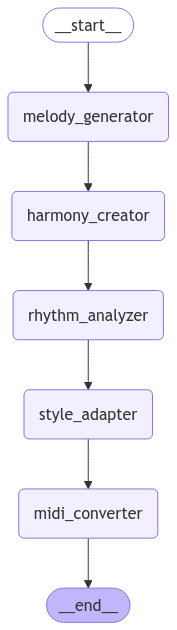

In [ ]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

##6. Run the workflow

In [ ]:
inputs = {
    "musician_input": "Write a sorrowful string quartet in C minor",
    "style": "Romantic era"

}

result = app.invoke(inputs)
print(f"MIDI File saved in {result['midi_file']}")

MIDI File saved in /tmp/tmpmiooimc2.mid


In [ ]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!fluidsynth -ni font.sf2 /tmp/tmpmiooimc2.mid -F output.wav -r 44100

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'output.wav'..


In [ ]:
from IPython.display import Audio
Audio("output.wav")